In [ ]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 64

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

print(train_data.size())

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers)


AttributeError: ignored

In [ ]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

In [ ]:
class Generator3(nn.Module):

    def __init__(self, device = "cuda"):
        super().__init__()
        
        # define hidden linear layers
        self.net = nn.Sequential(
            nn.Linear(100,128,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(128,256,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(256,512,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(512,784,device=device),
            
        )

        self.fc1 = nn.Linear(100, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 512)
        
        # final fully-connected layer
        self.fc4 = nn.Linear(512, 784)
        
        # dropout layer 
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # all hidden layers
        x = self.net(x)
        # final layer with tanh applied
        out = torch.tanh(x)
        out = torch.reshape(out,(-1,1,28,28))

        return out
    
class Discriminator0(nn.Module):

    def __init__(self,device="cuda"):

        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1,64,5,2,padding=2,device=device),
            nn.BatchNorm2d(64,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,128,5,2,padding=2,device=device),
            nn.BatchNorm2d(128,device=device),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(128,256,4,2,padding=2,device=device),
            nn.BatchNorm2d(256,device=device),
            nn.LeakyReLU(0.2,True),
            
        )
        self.ll = nn.Sequential(
            nn.Linear(256*4*4,1,device=device),
            nn.LeakyReLU(0.2,True),
        )
    
    def forward(self,x):
        x = self.net(x)
        x = torch.flatten(x,1)
        x = self.ll(x)
        return x

In [ ]:
class Generator(nn.Module):

    def __init__(self,device="cuda",input_size = 100, hidden_dim = 32, output_size = 784):

        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim*2, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim*4, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, output_size, device = device),
        )
    
    def forward(self, x):
        x = self.net(x)
        x = torch.tanh(x)
        x = torch.reshape(x,(-1,1,28,28))

        return x

In [ ]:
class Discriminator(nn.Module):

    def __init__(self, device = "cuda" ,input_size = 784, hidden_dim = 32, output_size = 1):

        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim, device = device),
            nn.LeakyReLU(0.2,True),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_size, device = device),
        
        )
    
    def forward(self,x):
        x = torch.flatten(x,1)
        x = self.net(x)
        return x


class Generator0(nn.Module):

    def __init__(self,device="cuda"):

        super().__init__()
        self.linear1 = nn.Linear(100,512*4*4,device=device)

        self.net1 = nn.Sequential(
            nn.ConvTranspose2d(512,256,4,2,padding=1,device=device),
            nn.BatchNorm2d(256,device=device),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,padding=2,device=device),
            nn.BatchNorm2d(128,device=device),
            nn.ReLU(True),
            nn.ConvTranspose2d(128,1,4,2,padding=1,device=device),
        )
    
    def forward(self,x):
        x = self.linear1(x)
        x = torch.reshape(x,(-1,512,4,4))
        #print(x.size())
        x = self.net1(x)
        x = torch.tanh(x)
        
        #print(x.size())

        return x
    

In [ ]:
# instantiate discriminator and generator
#D = Discriminator(input_size, d_hidden_size, d_output_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

G = Generator0()
D = Discriminator0()

G.to(device)
D.to(device)

print(D)
print()
print(G)

cuda:0
Discriminator0(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (ll): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)

Generator0(
  (linear1): Linear(in_features=100, out_features=8192, bias=True)
  (net1): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), 

In [ ]:
import torch.optim as optim

lr = 0.0002

criterion = nn.BCEWithLogitsLoss()
g_optimizer = optim.Adam(G.parameters(), lr)
d_optimizer = optim.Adam(D.parameters(), lr)

0


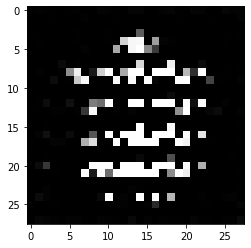

0


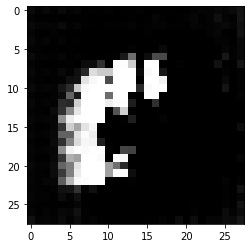

1


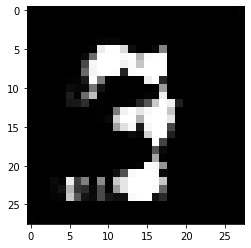

1


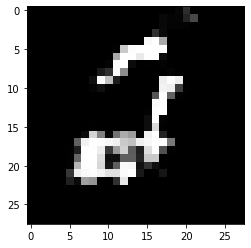

2


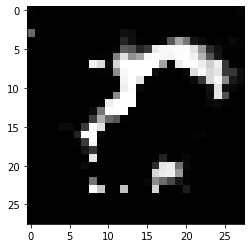

2


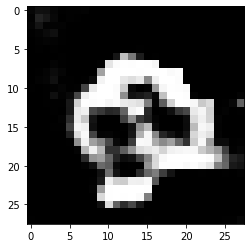

3


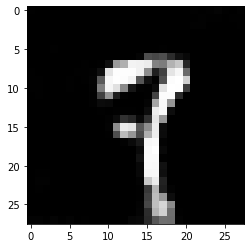

3


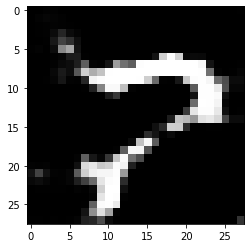

4


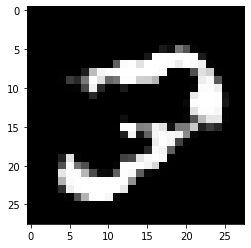

4


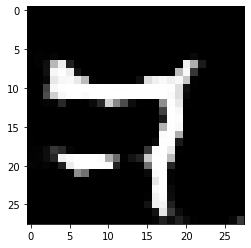

5


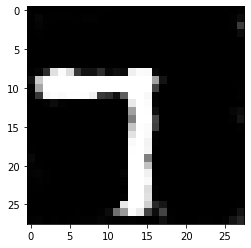

5


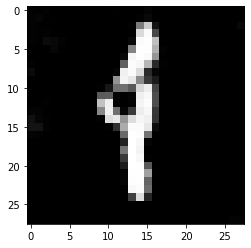

6


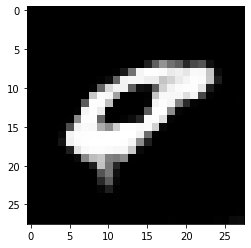

6


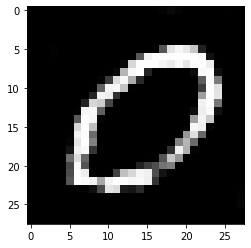

7


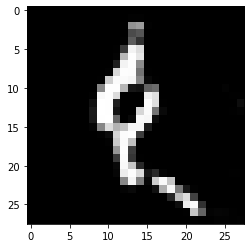

7


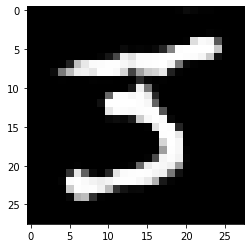

8


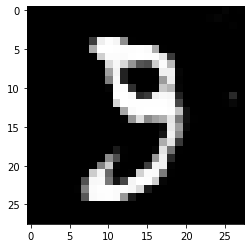

8


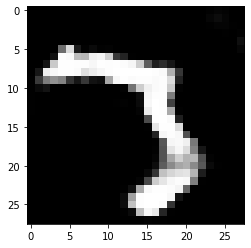

9


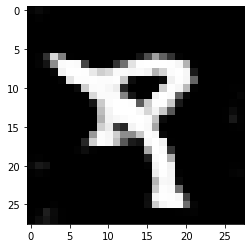

9


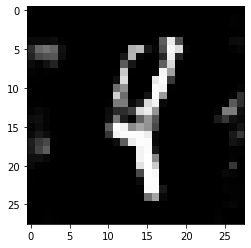

10


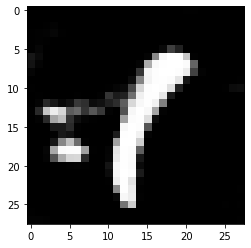

10


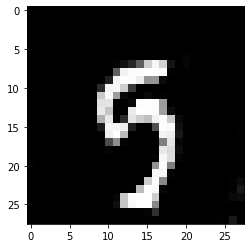

11


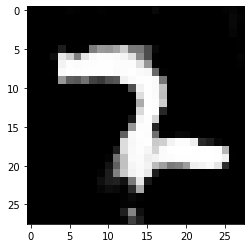

11


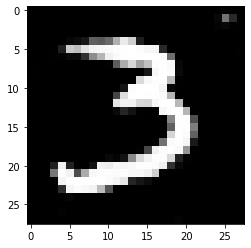

12


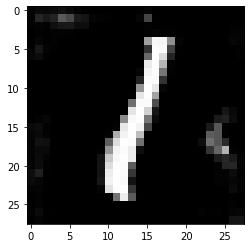

12


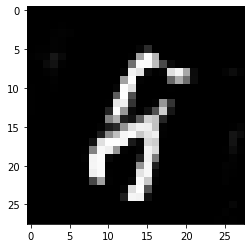

13


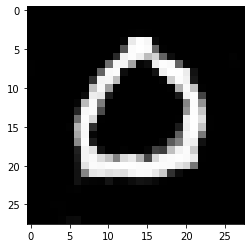

13


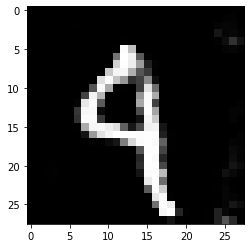

14


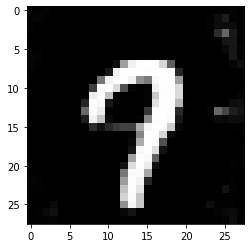

14


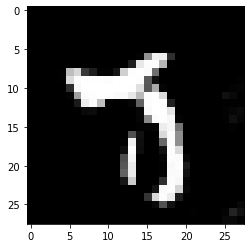

15


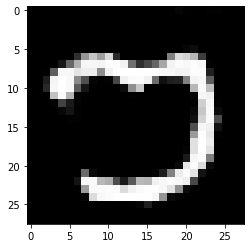

15


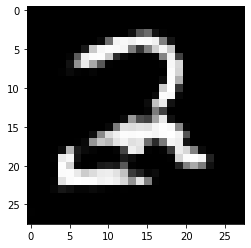

16


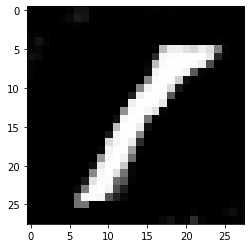

16


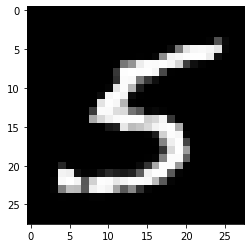

17


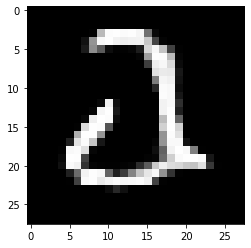

17


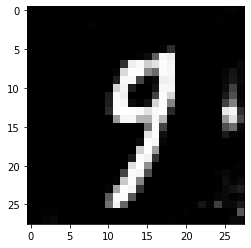

18


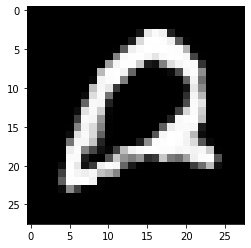

18


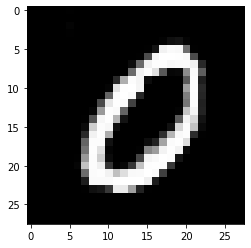

19


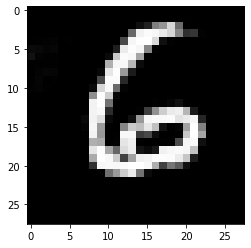

19


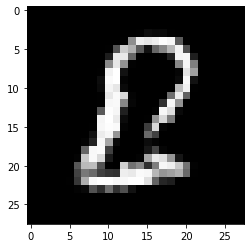

20


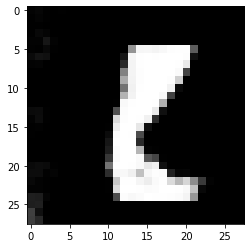

20


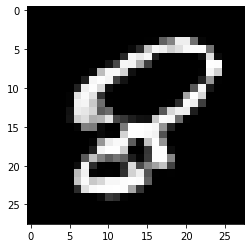

21


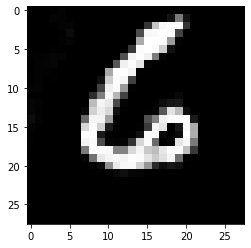

21


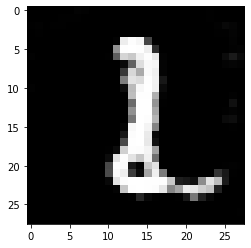

22


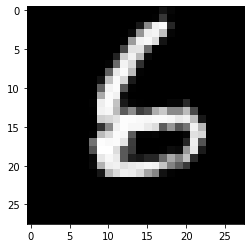

22


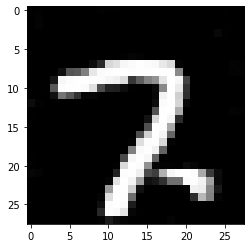

23


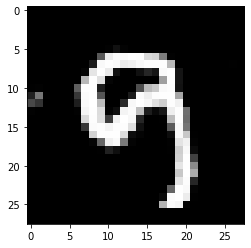

23


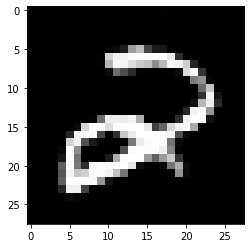

24


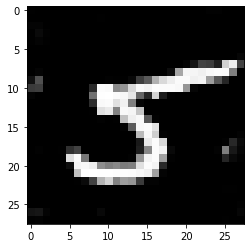

24


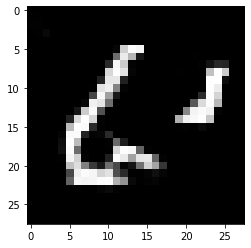

25


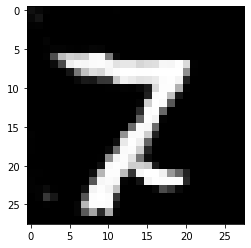

25


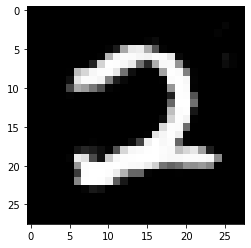

26


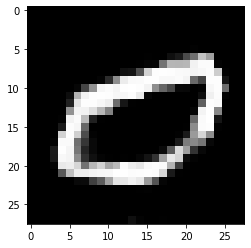

26


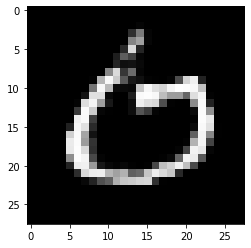

27


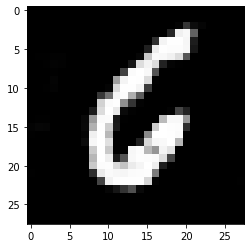

27


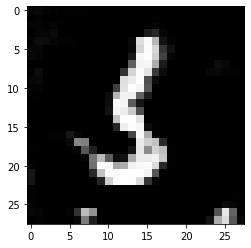

In [ ]:

for epoch in range(125):

    for i, (real_input,_) in enumerate(train_loader,0):
        
        batch_size1 = real_input.size(0)
        
        label_1 = torch.ones(batch_size1,1)
        label_0 = torch.zeros(batch_size1,1)

        label_0 = label_0.to(device)
        label_1 = label_1.to(device)

        z = np.random.uniform(-1, 1, size=(batch_size1, z_size))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        #z = Variable(z.cuda())

        #print(g_input.size())
        g_output = G(z)
        #g_output.to(device)

        real_input = real_input.to(device)
        r_input = real_input
        r_input = 2*r_input - 1
        r_input = r_input.to(device)

        d_optimizer.zero_grad()

        #print(g_output.size())
        #print()
        #print(r_input.size())

        #r_input = Variable(r_input.cuda())

        
        real_output = D(r_input)
        fake_output = D(g_output)

        #real_output = torch.flatten(real_output)
        #fake_output = torch.flatten(fake_output)
        #print(real_output.size())
        #print(label_1.size())

        #print(fake_output.size())
        #print(label_0.size())
        real_loss = criterion(real_output, label_1)
        fake_loss = criterion(fake_output, label_0)

        total_loss = real_loss + fake_loss
        total_loss.backward()

        d_optimizer.step()

        #---Training of Generator starts---

        g_optimizer.zero_grad()

        label1 = torch.ones(batch_size1,1)
        label1 = label1.to(device)

        #label1 = Variable(label1.cuda())

        z1 = np.random.uniform(-1, 1, size=(batch_size1, z_size))
        z1 = torch.from_numpy(z1).float()
        z1 = z1.to(device)

        #z1 = Variable(z1.cuda())

        G_out = G(z1)
        
        out = D(G_out)

        #out = torch.flatten(out)
        Gloss = criterion(out,label1)
        Gloss.backward()
        g_optimizer.step()

        if(i%400 == 399):
            inp = torch.randn(1,100)
            inp = inp.to(device)
            outpt = G(inp)
            print(epoch)

            img = outpt.detach()
            img = img.to("cpu")
            im = plt.imshow(img.reshape(28,28), cmap='Greys_r')
            plt.show()


        #----



## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

In [ ]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

In [ ]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])